In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

### Topology Transfer: From One Topology to Others
                            NO Training is Required!!!
* Source Domain: Nonresonant DAB Converter with Single L
* Target Domain: Resonant DAB Converter with LC Resonant Tank
    * Case 1: Lr is the same, fr = 1.1fs (capacitive)
    * Case 2: Lr is the same, fr = 0.9fs (inductive)
    * Case 3: Lr is the same, fr = 1.0fs (resistive)

In [3]:
# import the modules and functions
import torch
from pann_net import PANN, EulerCell_DAB
from pann_utils import evaluate
%matplotlib inline


# define circuit parameters and network variables
n, RL, Lr = 1, 120e-3, 63e-6
Ts = 1/50e3
Tslen = 100
dt = Ts/Tslen

dab_Euler_cell = torch.jit.script(EulerCell_DAB(dt, Lr, RL, n)) # define the Euler cell for DAB
pann_dab = torch.jit.script(PANN(dab_Euler_cell)) # define the PANN for DAB
print(pann_dab)

RecursiveScriptModule(
  original_name=PANN
  (cell): RecursiveScriptModule(original_name=EulerCell_DAB)
)


In [4]:
import numpy as np
from pann_utils import create_vpvs, get_inputs


# consider an exemplary case
D0, D1, D2 = 0.16, 1, 1
Vin, Vref = 200, 160
Tsim = 100*Ts # simulation time, considering 100 times of switching periods
# generate voltage waveforms (vp and vs) given one set of modulation parameters
vp, vs = create_vpvs(D0, D1, D2, Vin, Vref,
                     Tslen, dt, Tsim, Ts,
                     D1_cycle=0.5, D2_cycle=0.5)
t = np.arange(0, len(vp)*dt, dt)
inputs = np.hstack([vp[:, None], vs[:, None]])[None]
# convert to torch FloatTensor
inputs = torch.FloatTensor(inputs)
# initialize the state variable
state_dim = 1
state0 = torch.zeros((inputs.shape[0], 1, state_dim)) # it should be 0
# use PANN to infer the state variable iL
pann_dab.eval()
with torch.no_grad():
    # don't capture the computational graph, as this is not training
    states = pann_dab(inputs, state0)

In [5]:
from torch import nn


# Define the Implicit Euler Cell for DAB with LC Resonant Tank
class EulerCell_DAB_LC(nn.Module):
    # Used for DAB with series LC tank only
    def __init__(self, dt, Lr, RL, n, Cs, **kwargs):
        super(EulerCell_DAB_LC, self).__init__(**kwargs)
        self.dt = dt
        self.Lr = nn.Parameter(torch.Tensor([Lr]))
        self.RL = nn.Parameter(torch.Tensor([RL]))
        self.n = nn.Parameter(torch.Tensor([n]))
        self.Cs = nn.Parameter(torch.Tensor([Cs]))
        
    def forward(self, inputs, states):
        # physics of leakage inductor of conventional nonresonant DAB
        # iL_next = (states[:, 0]+(inputs[:, 0]-inputs[:, 1]*self.n)*self.dt/self.Lr)\/
        #             (1+self.RL*self.dt/self.Lr) # physics of iL
        
        # physics of resonant inductor iL
        iL_next = (states[:, 0]+(inputs[:, 0]-inputs[:, 1]*self.n-states[:, 1])*self.dt/self.Lr)/\
                    (1+self.RL*self.dt/self.Lr+self.dt**2/self.Lr/self.Cs)
        # physics of resonant capacitor vC
        vC_next = iL_next/self.Cs*self.dt+states[:, 1]
        
        states_next = torch.cat((iL_next[:, None], vC_next[:, None]), dim=-1)
        return states_next

In [6]:
##################################################
# Case 1: Lr is the same, fr = 1.1fs
# define the resonant capacitance
fr = 1.1/Ts
Cs = 1/pann_dab.cell.Lr.item()/(2*np.pi*fr)**2

# define the PANN model for DAB converters with LC resonant tank
dab_Euler_cell_LC = torch.jit.script(EulerCell_DAB_LC(dt, Lr, RL, n, Cs)) # define the Euler cell for DAB
pann_dab_LC = torch.jit.script(PANN(dab_Euler_cell_LC)) # define the PANN for DAB

# Consider the same inputs
state_dim = 2 # the dimensions become 2, for iL and vC, respectively
state0 = torch.zeros((inputs.shape[0], 1, state_dim)) # it should be 0
# use PANN to infer the state variable iL
pann_dab_LC.eval()
with torch.no_grad():
    # don't capture the computational graph, as this is not training
    states_LC = pann_dab_LC(inputs, state0)
    
    
##################################################
# Case 2: Lr is the same, fr = 0.9fs
# define the resonant capacitance
fr = 0.9/Ts
Cs = 1/pann_dab.cell.Lr.item()/(2*np.pi*fr)**2

# define the PANN model for DAB converters with LC resonant tank
dab_Euler_cell_LC = torch.jit.script(EulerCell_DAB_LC(dt, Lr, RL, n, Cs)) # define the Euler cell for DAB
pann_dab_LC = torch.jit.script(PANN(dab_Euler_cell_LC)) # define the PANN for DAB

# Consider the same inputs
state_dim = 2 # the dimensions become 2, for iL and vC, respectively
state0 = torch.zeros((inputs.shape[0], 1, state_dim)) # it should be 0
# use PANN to infer the state variable iL
pann_dab_LC.eval()
with torch.no_grad():
    # don't capture the computational graph, as this is not training
    states_LC2 = pann_dab_LC(inputs, state0)
    
    
##################################################
# Case 3: Lr is the same, fr = 1.0fs
# define the resonant capacitance
fr = 1.0/Ts
Cs = 1/pann_dab.cell.Lr.item()/(2*np.pi*fr)**2

# define the PANN model for DAB converters with LC resonant tank
dab_Euler_cell_LC = torch.jit.script(EulerCell_DAB_LC(dt, Lr, RL, n, Cs)) # define the Euler cell for DAB
pann_dab_LC = torch.jit.script(PANN(dab_Euler_cell_LC)) # define the PANN for DAB

# Consider the same inputs
state_dim = 2 # the dimensions become 2, for iL and vC, respectively
state0 = torch.zeros((inputs.shape[0], 1, state_dim)) # it should be 0
# use PANN to infer the state variable iL
pann_dab_LC.eval()
with torch.no_grad():
    # don't capture the computational graph, as this is not training
    states_LC3 = pann_dab_LC(inputs, state0)

<IPython.core.display.Javascript object>


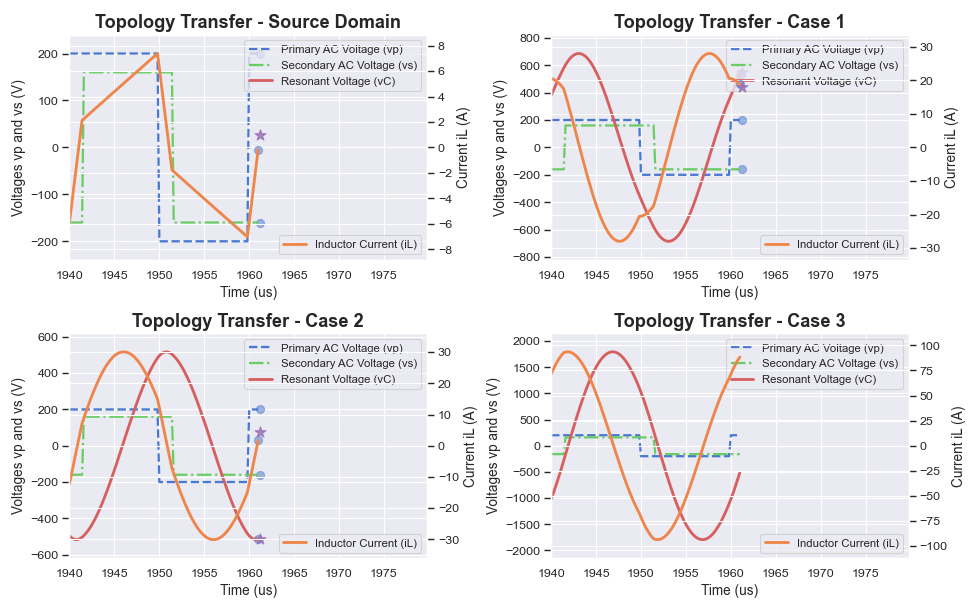

In [7]:
#################################################################################
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook
# if use google colab
# %matplotlib widget 


if len(inputs.shape)==3:
    t = t[-2*Tslen:]*1e6
    inputs = inputs[0, -2*Tslen:]
    states = states[0, -2*Tslen:]
    states_LC = states_LC[0, -2*Tslen:]
    states_LC2 = states_LC2[0, -2*Tslen:]
    states_LC3 = states_LC3[0, -2*Tslen:]
# Example data for vp and vs
# inputs: size (seqlen x inp_dim)
# states: size (seqlen x state_dim)
sns.set(style="darkgrid")  # Use a dark grid background for contrast

t, inputs, states = np.array(t), np.array(inputs), np.array(states)
# Create figure and subplots (two subplots: one for vp, one for vs)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 7.5))

axs_dualY = []
lines = []
dots = []
for i, (ax, _inputs, _states) in enumerate(zip([ax1, ax2, ax3, ax4],
                                               [inputs, inputs, inputs, inputs],
                                               [states, states_LC, states_LC2, states_LC3])):
    # Set limits for all plots
    ax.set_xlim(t.min(), t.max())
    if i == 0:
        ax.set_ylim(-_inputs.max()*1.2,  _inputs.max()*1.2)
    else:
        ax.set_ylim(-max(_inputs.max(), _states[:, 1].max())*1.2, 
                    max(_inputs.max(), _states[:, 1].max())*1.2)
    ax_2 = ax.twinx()
    ax_2.set_ylim(-_states[:, 0].max()*1.2, _states[:, 0].max()*1.2)
    axs_dualY.append(ax_2)

    # Labels and titles
    if i == 0:
        ax.set_title(f'Topology Transfer - Source Domain', fontsize=16, weight='bold')
    else:
        ax.set_title(f'Topology Transfer - Case {i}', fontsize=16, weight='bold')
    ax.set_xlabel('Time (us)', fontsize=12)
    ax.set_ylabel('Voltages vp and vs (V)', fontsize=12)
    ax_2.set_ylabel('Current iL (A)', fontsize=12)

    # Initialize empty lines for both plots
    line_1, = ax.plot([], [], lw=2, label='Primary AC Voltage (vp)', 
                        color=sns.color_palette("muted")[0], linestyle='--')
    line_2, = ax.plot([], [], lw=2, label='Secondary AC Voltage (vs)',
                       color=sns.color_palette("muted")[2], linestyle='-.')
    line_3, = ax_2.plot([], [], lw=2.5, label='Inductor Current (iL)', 
                        color=sns.color_palette("muted")[1], linestyle='-')
    line_4, = ax.plot([], [], lw=2.5, label='Resonant Voltage (vC)',
                       color=sns.color_palette("muted")[3], linestyle='-')
    lines.append([line_1, line_2, line_3, line_4])
    dot_1 = ax.scatter([], [], edgecolor=sns.color_palette("muted")[0], alpha=0.5,
                         s=50, color=sns.color_palette("muted")[0], marker="o")
    dot_2 = ax.scatter([], [], edgecolor=sns.color_palette("muted")[0], alpha=0.5,
                         s=50, color=sns.color_palette("muted")[0], marker="o")
    dot_3 = ax_2.scatter([], [], edgecolor=sns.color_palette("muted")[0], alpha=0.5,
                         s=50, color=sns.color_palette("muted")[0], marker="o")
    dot_4 = ax_2.scatter([], [], edgecolor=sns.color_palette("muted")[4], alpha=0.8,
                         s=100, color=sns.color_palette("muted")[4], marker="*")
    dot_5 = ax.scatter([], [], edgecolor=sns.color_palette("muted")[0], alpha=0.5,
                         s=50, color=sns.color_palette("muted")[0], marker="o")
    dot_6 = ax.scatter([], [], edgecolor=sns.color_palette("muted")[4], alpha=0.8,
                         s=100, color=sns.color_palette("muted")[4], marker="*")
    dots.append([dot_1, dot_2, dot_3, dot_4, dot_5, dot_6])

    # Add grids and legends
    ax.grid(True)
    ax.legend(loc='upper right', fontsize=10)
    ax_2.legend(loc='lower right', fontsize=10)

    
# Initialize the animation
def init():
    for fig_lines in lines:
        for line in fig_lines:
            line.set_data([], [])
    for fig_dots in dots:
        for dot in fig_dots:
            dot.set_offsets(np.empty((0, 2)))  # Initialize empty scatter for subplot
    return lines, dots

# Update the plots
def update(frame):
    for i, (fig_lines, _inputs, _states) in enumerate(zip(lines, 
                                                          [inputs, inputs, inputs, inputs],
                                                          [states, states_LC, states_LC2, states_LC3])):
        fig_lines[0].set_data(t[:frame+1], _inputs[:frame+1, 0])  # Update vp plot progressively
        fig_lines[1].set_data(t[:frame+1], _inputs[:frame+1, 1])  # Update vs plot progressively
        fig_lines[2].set_data(t[:frame+1], _states[:frame+1, 0])  # Update iL plot progressively
        if i != 0:
            fig_lines[3].set_data(t[:frame+1], _states[:frame+1, 1])  # Update vC plot progressively
        
            
    for i, (fig_dots, _inputs, _states) in enumerate(zip(dots,
                                                         [inputs, inputs, inputs],
                                                         [states, states_LC, states_LC2])):
        fig_dots[0].set_offsets(np.c_[t[frame+1], _inputs[frame+1, 0]])
        fig_dots[1].set_offsets(np.c_[t[frame+1], _inputs[frame+1, 1]])
        fig_dots[2].set_offsets(np.c_[t[frame], _states[frame, 0]])
        fig_dots[3].set_offsets(np.c_[t[frame+1], _states[frame+1, 0]])
        if i != 0:
            fig_dots[4].set_offsets(np.c_[t[frame], _states[frame, 1]])
            fig_dots[5].set_offsets(np.c_[t[frame+1], _states[frame+1, 1]])
    return lines, dots


# Create the animation
ani = FuncAnimation(fig, update, frames=len(t)-1, 
                    init_func=init, blit=False, interval=10)

# ani.save('DAB-Topology Transfer.gif', writer='pillow')

# Show the plot
plt.tight_layout()  # Adjust layout for better fit
# Display the animation in Jupyter
plt.show()